# 🔐 Styling

In [447]:
%%HTML
<style>
body {
    --vscode-font-family : 'Nasalization';
}

.dataframe {
    font-family : 'Futura';
    # font-family : 'Century Gothic';
    border : 2px solid #252422;
    border-radius : 5px;
    overflow : hidden;
}

.dataframe tr th {
    text-align : center;
}

.dataframe td {
    paddign : 10px;
    text-align : left;
}

.dataframe tr:hover{
    background-color : #ef233c;
}

</style>

# 🛳️ Importation

In [448]:
import calendar
import datetime as dt

import psycopg2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from ipywidgets import widgets, interact

# 🎯 Main

## 📍 Collect data

In [449]:
# Create database connection

conn = ''

try :
    conn = psycopg2.connect(
        host = "localhost",
        port = "5432",
        user = "postgres",
        password = "postgres",
        dbname = "BudgetManagement"
    )    

except Exception as e: 
    print(e)

# Connect to Database and get informations
cursor = conn.cursor()

In [450]:
query = 'SELECT * FROM vue_Flux'
cursor.execute(query)

colnames = [col.name for col in cursor.description]
rows = cursor.fetchall()

data = pd.DataFrame(columns=colnames, data=rows)
data.head()

,ID Flux,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Date,Montant,Tags,Description
0,1,Entreprise,Sortie,Variable,Epargne,Livret A,2024-09-02,350.00000,#Epargne,Epargne août et réserve
1,2,Entreprise,Sortie,Variable,Divertissement,Brasserie,2024-09-02,9.00000,#Soirée,Soirée inté ENSIMAG
2,3,Entreprise,Entrée,Fixe,Emploi,Salaire,2024-09-02,1329.00000,#Salaire,Salaire août
3,4,Entreprise,Sortie,Fixe,Logement,Loyer,2024-09-02,390.00000,#Loyer,Loyer septembre 2024
4,5,Entreprise,Sortie,Exceptionnel,Impôts,Impôts,2024-09-03,103.00000,#Ecole,CVEC pour IUT


## 📍 Process

In [451]:
data['Date'] = pd.to_datetime(data['Date'])
data['Montant'] = data['Montant'].astype('float')

## 📍 Filter data

In [452]:
def get_month_end_date(date) :
    date = pd.to_datetime(date)
    month_end_day = calendar.monthrange(date.year, date.month)[1]
    month_end = date.replace(day=month_end_day)
    return month_end

In [453]:
# Relative dates from today
today = dt.datetime.today()
today = dt.datetime.combine(dt.datetime.today().date(), dt.time.min)

week_start = today - dt.timedelta(today.weekday())
week_end = week_start + dt.timedelta(days=6)

month_start = today.replace(day=1)
month_end = get_month_end_date(month_start)

# Specific dates
custom_start = dt.datetime(2025, 6, 1).date()
custom_end = dt.datetime(2025, 6, 15).date()
custom_month_end = get_month_end_date(custom_start)

## 📍 Calendar

In [454]:
dim_calendar_start = data.Date.min()
dim_calendar_start = dim_calendar_start.replace(month=1, day=1)

dim_calendar_end = data.Date.max()
dim_calendar_end = dim_calendar_end.replace(month=12, day=31)

dim_calendar = pd.date_range(start=dim_calendar_start, end=dim_calendar_end)
dim_calendar = pd.DataFrame(dim_calendar, columns=['Date'])

# Add features
dim_calendar['Annee'] = dim_calendar['Date'].dt.year
dim_calendar['Month'] = dim_calendar['Date'].dt.month
dim_calendar['Month Name'] = dim_calendar['Date'].dt.month_name()
dim_calendar['Week'] = dim_calendar['Date'].dt.isocalendar().week.astype('int32')

dim_calendar['Date'] = dim_calendar['Date']
dim_calendar['Annee'] = dim_calendar['Annee'].astype('str')
dim_calendar['Month'] = dim_calendar['Month'].astype('str').str.zfill(2)
dim_calendar['Week'] = dim_calendar['Week'].astype('str').str.zfill(2)

dim_calendar

,Date,Annee,Month,Month Name,Week
0,2024-01-01,2024,01,January,01
1,2024-01-02,2024,01,January,01
2,2024-01-03,2024,01,January,01
3,2024-01-04,2024,01,January,01
4,2024-01-05,2024,01,January,01
...,...,...,...,...,...
726,2025-12-27,2025,12,December,52
727,2025-12-28,2025,12,December,52
728,2025-12-29,2025,12,December,01
729,2025-12-30,2025,12,December,01


# 🎭 Visualisation

## 📋 Besoins

- Dimensions :
    - ✅ Temps
    - Catégorie
    - Sous-Catégorie

- Mesures :
    - ✅ Entrée
    - ✅ Sortie
    - ✅ Disponible
    - ✅ Entrée en Epargne
    - ✅ Sortie en Epargne
    - ✅ Epargné

- Visuels : 
    - 📜 Page N°1 :
        - Vignettes des mesures
        - ✅ Sortie par Catégorie
        - ❌ Graphique en camembert pour les top 5 dépenses
        - ✅ Dépenses sur le temps avec une hue = 'Période'

    - 📜 Page N°2 :
        - ✅ Sortie par Catégorie, Sous-Catégorie
        - ✅ Tableau des dépenses
    
    - 📜 Page N°3 :
        - ✅ Entrée par temps
        - ✅ Sortie par temps

    - 📜 Page N°4 :
        - Visuels target

## 🎨 Couleurs

In [455]:
custom_colors_palette = [
    [
        '#F72585',
        '#7209B7',
        '#3A0CA3',
        '#4361EE',
        '#4CC9F0',
    ],

    [
        '#390099',
        '#9E0059',
        '#FF0054',
        '#FF5400',
        '#FFBD00',
    ],

    [
        '#ff9f1c',
        '#ffbf69',
        '#ffffff',
        '#cbf3f0',
        '#2ec4b6',
    ],

    [
        '#22162b',
        '#451f55',
        '#724e91',
        '#e54f6d',
        '#f8c630',
    ],
        
    [
        '#5465ff',
        '#788bff',
        '#9bb1ff',
        '#bfd7ff',
        '#e2fdff',
    ],
]

In [456]:
custom_colors_palette = [
    '#F72585',
    '#7209B7',
    '#3A0CA3',
    '#4361EE',
    '#4CC9F0',

    '#390099',
    '#9E0059',
    '#FF0054',
    '#FF5400',
    '#FFBD00',

    '#ff9f1c',
    '#ffbf69',
    '#ffffff',
    '#cbf3f0',
    '#2ec4b6',

    '#22162b',
    '#451f55',
    '#724e91',
    '#e54f6d',
    '#f8c630',

    '#5465ff',
    '#788bff',
    '#9bb1ff',
    '#bfd7ff',
    '#bfd7ff',
]

In [457]:
custom_colors_palette_display = sns.palettes.color_palette(custom_colors_palette)
custom_colors_palette_display

[(0.9686274509803922, 0.1450980392156863, 0.5215686274509804),
 (0.4470588235294118, 0.03529411764705882, 0.7176470588235294),
 (0.22745098039215686, 0.047058823529411764, 0.6392156862745098),
 (0.2627450980392157, 0.3803921568627451, 0.9333333333333333),
 (0.2980392156862745, 0.788235294117647, 0.9411764705882353),
 (0.2235294117647059, 0.0, 0.6),
 (0.6196078431372549, 0.0, 0.34901960784313724),
 (1.0, 0.0, 0.32941176470588235),
 (1.0, 0.32941176470588235, 0.0),
 (1.0, 0.7411764705882353, 0.0),
 (1.0, 0.6235294117647059, 0.10980392156862745),
 (1.0, 0.7490196078431373, 0.4117647058823529),
 (1.0, 1.0, 1.0),
 (0.796078431372549, 0.9529411764705882, 0.9411764705882353),
 (0.1803921568627451, 0.7686274509803922, 0.7137254901960784),
 (0.13333333333333333, 0.08627450980392157, 0.16862745098039217),
 (0.27058823529411763, 0.12156862745098039, 0.3333333333333333),
 (0.4470588235294118, 0.3058823529411765, 0.5686274509803921),
 (0.8980392156862745, 0.30980392156862746, 0.42745098039215684),
 (0.9725490196078431, 0.7764705882352941, 0.18823529411764706),
 (0.32941176470588235, 0.396078431372549, 1.0),
 (0.47058823529411764, 0.5450980392156862, 1.0),
 (0.6078431372549019, 0.6941176470588235, 1.0),
 (0.7490196078431373, 0.8431372549019608, 1.0),
 (0.7490196078431373, 0.8431372549019608, 1.0)]

## 📐 Mesures

In [458]:
def calculate_entree(df) :
    result = df[df['Type de flux'] == 'Entrée']['Montant'].sum()
    return result

def calculate_sortie(df) :
    result = df[df['Type de flux'] == 'Sortie']['Montant'].sum()
    return result

def calculate_disponible(df) :
    return calculate_entree(df) - calculate_sortie(df)

def calculate_entree_depuis_epargne(df) :
    result = df[
            (df['Type de flux'] == 'Entrée')
        &   (df['Catégorie'] == 'Epargne')
    ]['Montant'].sum()
    return result

def calculate_sortie_en_epargne(df) :
    result = df[
            (df['Type de flux'] == 'Sortie')
        &   (df['Catégorie'] == 'Epargne')
    ]['Montant'].sum()
    return result

def calculate_epargne(df) :
    return calculate_entree_depuis_epargne(df) - calculate_sortie_en_epargne(df)

## 📕 Fonctions

### 📝 plot_sur_le_temps

In [459]:
def plot_flux_sur_le_temps(donnees) :
    data_entree_sortie = donnees.copy()

    # Grouper les valeurs
    data_entree_sortie = data_entree_sortie.groupby(['Date', 'Période','Type de flux'])['Montant'].sum().reset_index()
    data_entree_sortie = data_entree_sortie.sort_values('Date')

    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= data_entree_sortie['Date'].min())
        &   (dim_calendar['Date'] <= get_month_end_date(donnees['Date'].min()))
    ]['Date']

    # Gestion des valeurs nulles
    data_entree_sortie = data_entree_sortie.merge(month_days_list, how='right')
    data_entree_sortie['Période'] = data_entree_sortie['Période'].fillna('---')
    data_entree_sortie['Type de flux'] = data_entree_sortie['Type de flux'].fillna('---')
    data_entree_sortie['Montant'] = data_entree_sortie['Montant'].fillna(0)

    # Ajout de couleurs
    dict_periode_couleur = {
        'Entreprise' : '#390099',
        'Ecole' : '#9E0059',
        'Vacances' : '#FF0054',
        '---' : '---'
    }

    dict_periode_couleur = dict(zip(data_entree_sortie['Période'].unique(), custom_colors_palette))
    data_entree_sortie['Couleur'] = data_entree_sortie['Période'].map(dict_periode_couleur)


    entree_data = data_entree_sortie[data_entree_sortie['Type de flux'] == 'Entrée']
    sortie_data = data_entree_sortie[data_entree_sortie['Type de flux'] == 'Sortie']

    fig, ax = plt.subplots(figsize=(30, 5))

    plt.bar(sortie_data['Date'], sortie_data['Montant'], label='Sortie', color=sortie_data['Couleur'])
    plt.scatter(entree_data['Date'], entree_data['Montant'], label='Entrée', color='#4CC9F0')

    ax.set_xticks(data_entree_sortie['Date'], data_entree_sortie['Date'].dt.date, rotation=90)

    handles = []
    for key, color in dict_periode_couleur.items() :
        patch = mpatches.Patch(label=key, color=color)
        handles.append(patch)

    plt.title('Entrée et Sortie sur le mois')
    plt.legend()
    plt.show()

### 📝 plot_depenses_par_categorie

In [460]:
def plot_depenses_par_categorie(donnees) : 
    sortie_categorie = donnees.copy()
    sortie_categorie = sortie_categorie[sortie_categorie['Type de flux'] == 'Sortie']
    sortie_categorie = sortie_categorie.groupby(['Catégorie'])['Montant'].sum().reset_index()
    sortie_categorie = sortie_categorie.sort_values('Montant', ascending=False)

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(sortie_categorie['Catégorie'], sortie_categorie['Montant'], color='#f8c630')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.2)

    plt.title('Dépenses par Catégorie')
    plt.yticks(np.arange(0, sortie_categorie['Montant'].max() * 1.2, 100))
    plt.show()

### 📝 plot_depenses_par_ss_categorie

In [461]:
def plot_depenses_par_ss_categorie(donnees, categories) :
    sortie_ss_categorie = donnees.copy()

    if len(categories) == 0 :
        categories = donnees['Catégorie'].unique()

    
    sortie_ss_categorie = sortie_ss_categorie[
            (sortie_ss_categorie['Type de flux'] == 'Sortie')
        &   (sortie_ss_categorie['Catégorie'].isin(categories))
    ]
    sortie_ss_categorie = sortie_ss_categorie.groupby(['Catégorie', 'Sous-catégorie'])['Montant'].sum().reset_index()
    sortie_ss_categorie = sortie_ss_categorie.sort_values(['Montant', 'Catégorie', 'Sous-catégorie'], ascending=False)

    dict_couleur = dict(zip(sortie_ss_categorie['Catégorie'].unique(), custom_colors_palette))
    sortie_ss_categorie['Couleur'] = sortie_ss_categorie['Catégorie'].map(dict_couleur)


    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(sortie_ss_categorie['Sous-catégorie'], sortie_ss_categorie['Montant'], color=sortie_ss_categorie['Couleur'])
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.2)

    handles = []
    for key, color in dict_couleur.items() :
        patch = mpatches.Patch(label=key, color=color)
        handles.append(patch)

    plt.title('Dépenses par Sous-Catégorie')
    plt.yticks(np.arange(0, sortie_ss_categorie['Montant'].max() * 1.2, 100))
    plt.legend(handles = handles)
    plt.show()

### 📝 plot_entree_sur_temps

In [462]:
def plot_entree_sur_temps(donnees, period) :
    data = donnees.copy()
    data = data[data['Type de flux'] == 'Entrée']

    data_columns = ['Date', 'Type de flux', 'Période', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Montant']
    data_columns = ['Date', 'Montant']
    data = data[data_columns]

    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= donnees['Date'].min())
        &   (dim_calendar['Date'] <= donnees['Date'].max())
    ]['Date']


    data = data.merge(month_days_list, how='right')
    data = data.merge(dim_calendar, how='inner')

    data['Week_Format'] = 'W' + data['Week']
    data['Year-Month'] = data['Annee'] + '-' + data['Month']
    data['Year-Week'] = data['Annee'] + '-' + data['Week_Format']

    dict_groupby_columns = {
        'year' : 'Annee',
        'month' : 'Year-Month',
        'week' : 'Year-Week',
    }

    data = data.groupby(dict_groupby_columns[period])['Montant'].sum()
    data = data.reset_index()

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(data[dict_groupby_columns[period]], data['Montant'], color='#2ec4b6')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.5)

    plt.title('Entrée sur le temps')
    plt.show()

### 📝 plot_depenses_sur_temps

In [463]:
def plot_depenses_sur_temps(donnees, period) :
    data = donnees.copy()
    data = data[data['Type de flux'] == 'Sortie']

    data_columns = ['Date', 'Type de flux', 'Période', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Montant']
    data_columns = ['Date', 'Montant']
    data = data[data_columns]

    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= donnees['Date'].min())
        &   (dim_calendar['Date'] <= donnees['Date'].max())
    ]['Date']


    data = data.merge(month_days_list, how='right')
    data = data.merge(dim_calendar, how='inner')

    data['Week_Format'] = 'W' + data['Week']
    data['Year-Month'] = data['Annee'] + '-' + data['Month']
    data['Year-Week'] = data['Annee'] + '-' + data['Week_Format']

    dict_groupby_columns = {
        'year' : 'Annee',
        'month' : 'Year-Month',
        'week' : 'Year-Week',
    }

    data = data.groupby(dict_groupby_columns[period])['Montant'].sum()
    data = data.reset_index()

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(data[dict_groupby_columns[period]], data['Montant'], color='#ffbf69')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.5)

    plt.title('Dépenses sur le temps')
    plt.show()

## 📜 Page N°1

In [464]:
# Définitions des filtres
page_1_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_1_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_1_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_1_filter_period_start = month_start
page_1_filter_period_end = month_end

page_1_filter_categorie = [

]
page_1_filter_ss_categorie = [

]

if len(page_1_filter_categorie) == 0 :
    page_1_filter_categorie = data['Catégorie'].unique()
if len(page_1_filter_ss_categorie) == 0 :
    page_1_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_1_data = data.copy()
page_1_data = page_1_data[
        (page_1_data['Période'].isin(page_1_filter_periode))
    &   (page_1_data['Type de flux'].isin(page_1_filter_type_flux))
    &   (page_1_data['Fixes'].isin(page_1_filter_fixes))
    &   (page_1_data['Date'] >= page_1_filter_period_start)
    &   (page_1_data['Date'] <= page_1_filter_period_end)
    &   (page_1_data['Catégorie'].isin(page_1_filter_categorie))
    &   (page_1_data['Sous-catégorie'].isin(page_1_filter_ss_categorie))
]

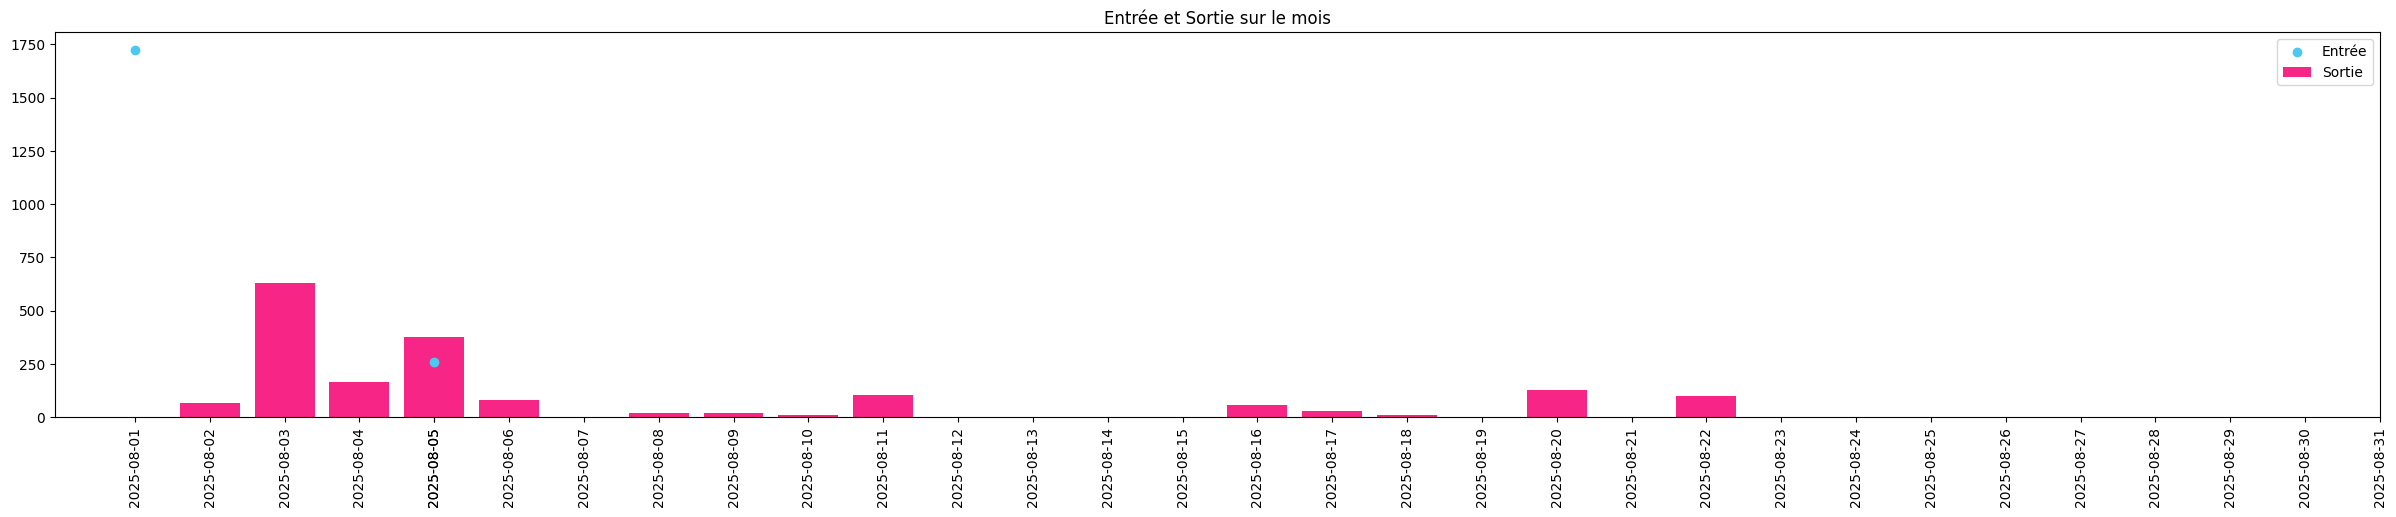

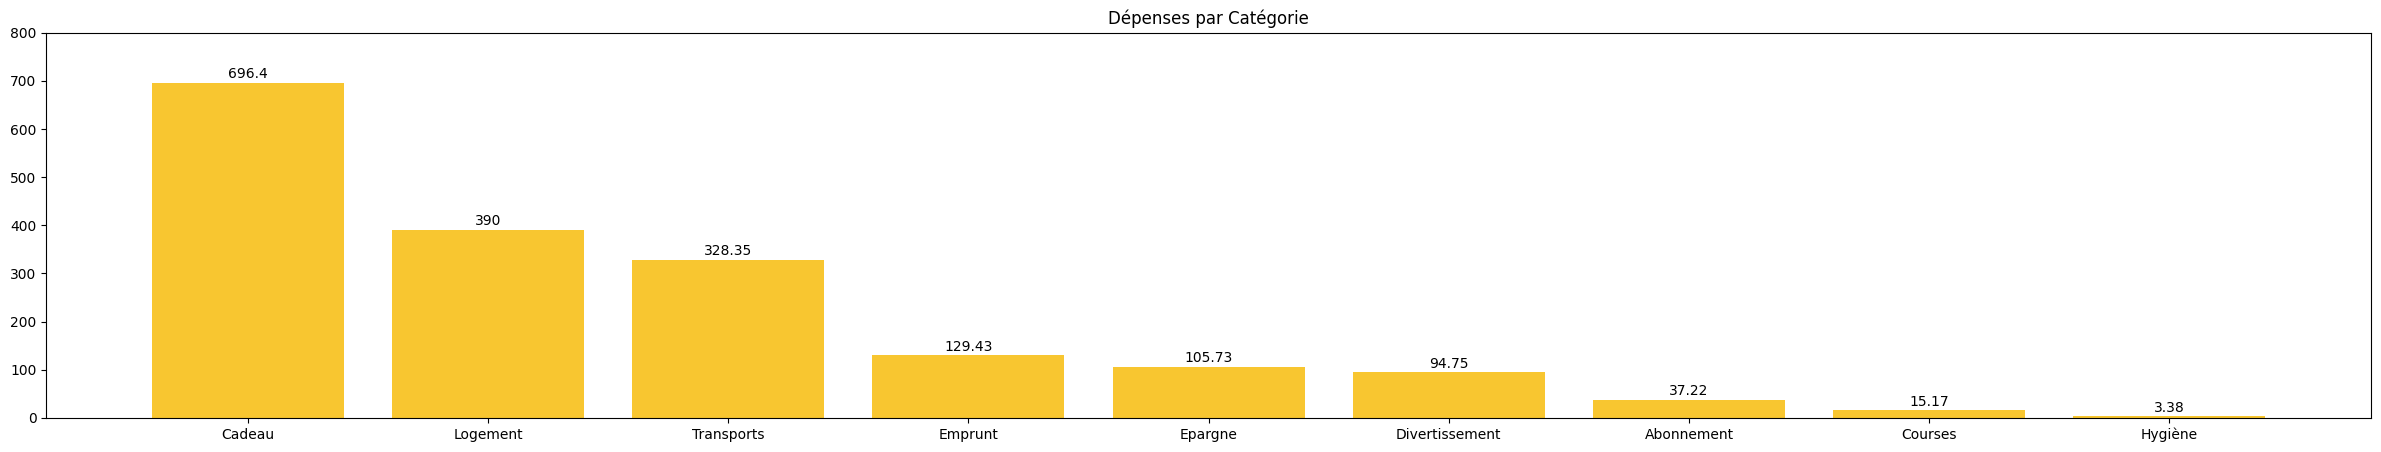

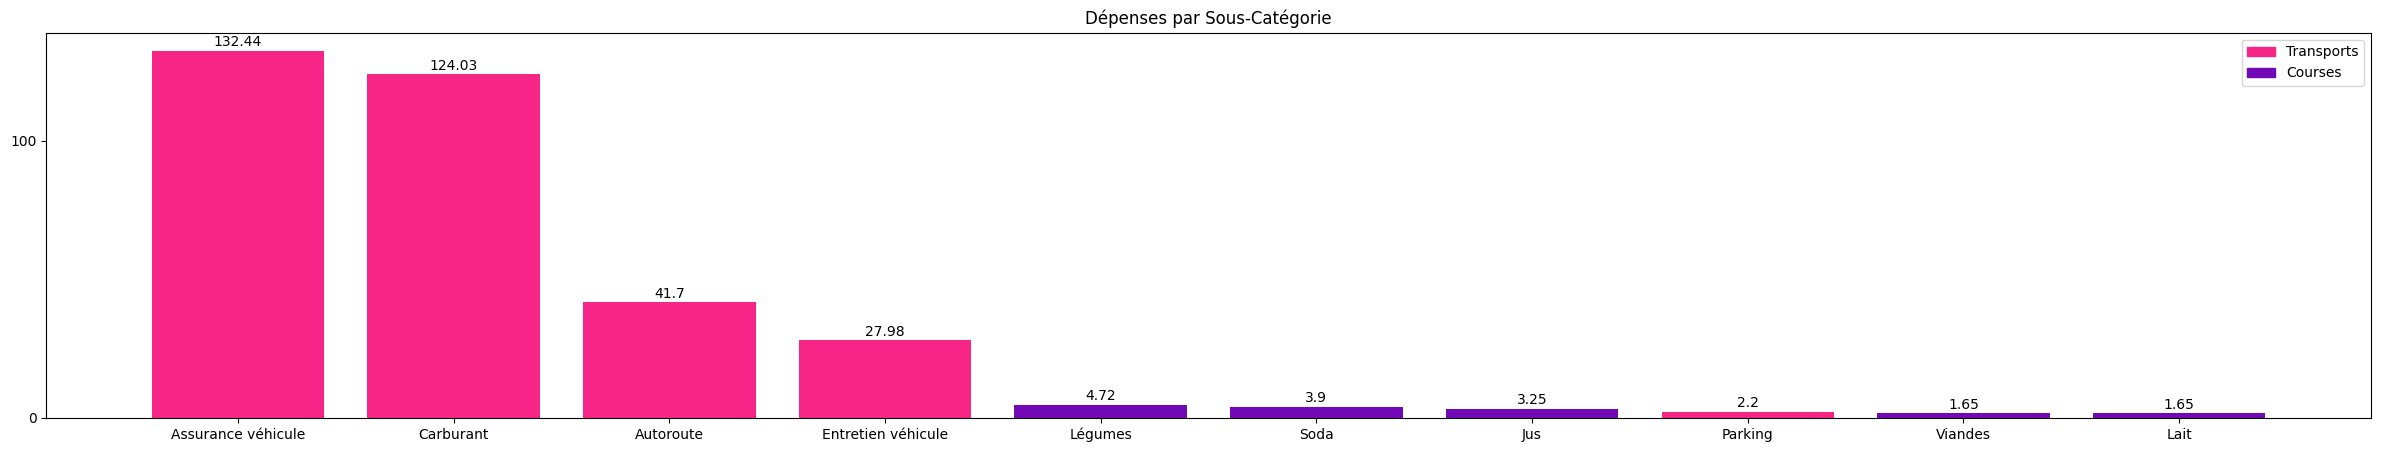

In [465]:
plot_flux_sur_le_temps(page_1_data)
plot_depenses_par_categorie(page_1_data)
plot_depenses_par_ss_categorie(page_1_data, ['Transports', 'Courses'])


## 📜 Page N°2

In [466]:
# Définitions des filtres
page_2_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_2_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_2_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_2_filter_period_start = month_start
page_2_filter_period_end = month_end

page_2_filter_categorie = [

]
page_2_filter_ss_categorie = [

]

if len(page_2_filter_categorie) == 0 :
    page_2_filter_categorie = data['Catégorie'].unique()
if len(page_2_filter_ss_categorie) == 0 :
    page_2_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_2_data = data.copy()
page_2_data = page_2_data[
        (page_2_data['Période'].isin(page_2_filter_periode))
    &   (page_2_data['Type de flux'].isin(page_2_filter_type_flux))
    &   (page_2_data['Fixes'].isin(page_2_filter_fixes))
    &   (page_2_data['Date'] >= page_2_filter_period_start)
    &   (page_2_data['Date'] <= page_2_filter_period_end)
    &   (page_2_data['Catégorie'].isin(page_2_filter_categorie))
    &   (page_2_data['Sous-catégorie'].isin(page_2_filter_ss_categorie))
]

page_2_data['Entrée'] = np.where(page_2_data['Type de flux'] == 'Entrée', page_2_data['Montant'], '---')
page_2_data['Sortie'] = np.where(page_2_data['Type de flux'] == 'Sortie', page_2_data['Montant'], '---')

page_2_columns = ['ID Flux', 'Date', 'Période', 'Type de flux', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Entrée', 'Sortie', 'Description', 'Tags']

page_2_data[page_2_columns]

,ID Flux,Date,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Entrée,Sortie,Description,Tags
931,980,2025-08-01,Entreprise,Entrée,Fixe,Emploi,Salaire,1721.64,---,Salaire Juillet 2025,#salaire
932,981,2025-08-03,Entreprise,Sortie,Fixe,Cadeau,Famille,---,200.0,Cadeau maman et papa,#famille
933,982,2025-08-03,Entreprise,Sortie,Fixe,Logement,Loyer,---,390.0,Loyer Août 2025,#loyer
934,983,2025-08-03,Entreprise,Sortie,Fixe,Epargne,Livret A,---,12.23,Reste Juillet 2025,#revolut
935,984,2025-08-04,Entreprise,Sortie,Fixe,Abonnement,Mobile,---,0.99,Icloud,#apple
936,985,2025-08-04,Entreprise,Sortie,Fixe,Abonnement,Streaming,---,14.99,Netflix,3netflix
937,986,2025-08-03,Entreprise,Sortie,Variable,Transports,Parking,---,2.2,Sortie Chamonix parc de jeu,#famille
938,987,2025-08-05,Entreprise,Sortie,Variable,Cadeau,Famille,---,106.5,Virement Thiwya pour Rams et Ranj Malte,#malte
939,988,2025-08-05,Entreprise,Sortie,Variable,Epargne,Revolut,---,93.5,Epargne sur Revolut,#epargne
940,989,2025-08-04,Entreprise,Sortie,Variable,Transports,Entretien véhicule,---,13.99,Pommeau de vitesse Simba,#amazon


## 📜 Page N°3

In [467]:
# Définitions des filtres
page_3_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_3_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_3_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_3_filter_period_start = '2025-04-01'
page_3_filter_period_end = month_end

page_3_filter_categorie = [

]
page_3_filter_ss_categorie = [

]

if len(page_3_filter_categorie) == 0 :
    page_3_filter_categorie = data['Catégorie'].unique()
if len(page_3_filter_ss_categorie) == 0 :
    page_3_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_3_data = data.copy()
page_3_data = page_3_data[
        (page_3_data['Période'].isin(page_3_filter_periode))
    &   (page_3_data['Type de flux'].isin(page_3_filter_type_flux))
    &   (page_3_data['Fixes'].isin(page_3_filter_fixes))
    &   (page_3_data['Date'] >= page_3_filter_period_start)
    &   (page_3_data['Date'] <= page_3_filter_period_end)
    &   (page_3_data['Catégorie'].isin(page_3_filter_categorie))
    &   (page_3_data['Sous-catégorie'].isin(page_3_filter_ss_categorie))
]
page_3_data

,ID Flux,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Date,Montant,Tags,Description
577,591,Ecole,Entrée,Fixe,Emploi,Salaire,2025-04-01,1755.14,#salaire,Salaire Mars 2025
578,592,Ecole,Sortie,Fixe,Cadeau,Famille,2025-04-01,200.00,#famille,Cadeau maman et papa
579,593,Ecole,Sortie,Fixe,Logement,Loyer,2025-04-01,390.00,#loyer,Loyer Avril 2025
580,594,Ecole,Sortie,Fixe,Divertissement,Informatique,2025-04-03,313.25,#iPhone,Darty iPhone
581,595,Ecole,Entrée,Fixe,Aide,CAF,2025-04-04,230.56,#caf,Aide CAF
...,...,...,...,...,...,...,...,...,...,...
977,1026,Entreprise,Sortie,Variable,Courses,Légumes,2025-08-18,1.75,#taboulé,Courses Carrefour
978,1027,Entreprise,Sortie,Fixe,Emprunt,Bancaire,2025-08-20,129.43,#lcl,Emprunt
979,1028,Entreprise,Sortie,Fixe,Transports,Carburant,2025-08-22,64.08,#gazole,Gazole Flash
980,1029,Entreprise,Sortie,Fixe,Divertissement,Cantine,2025-08-22,30.00,#elior,Cantine Thales Elior


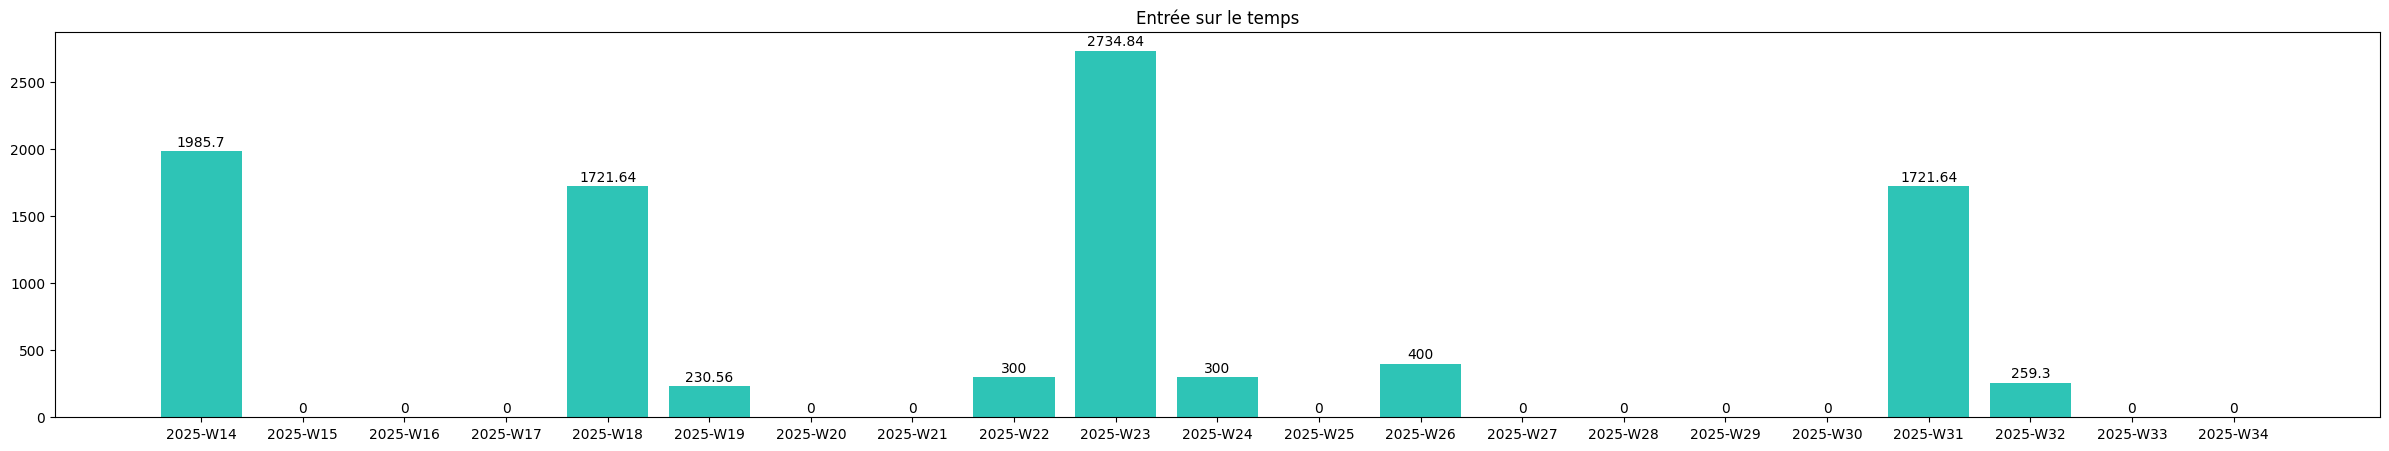

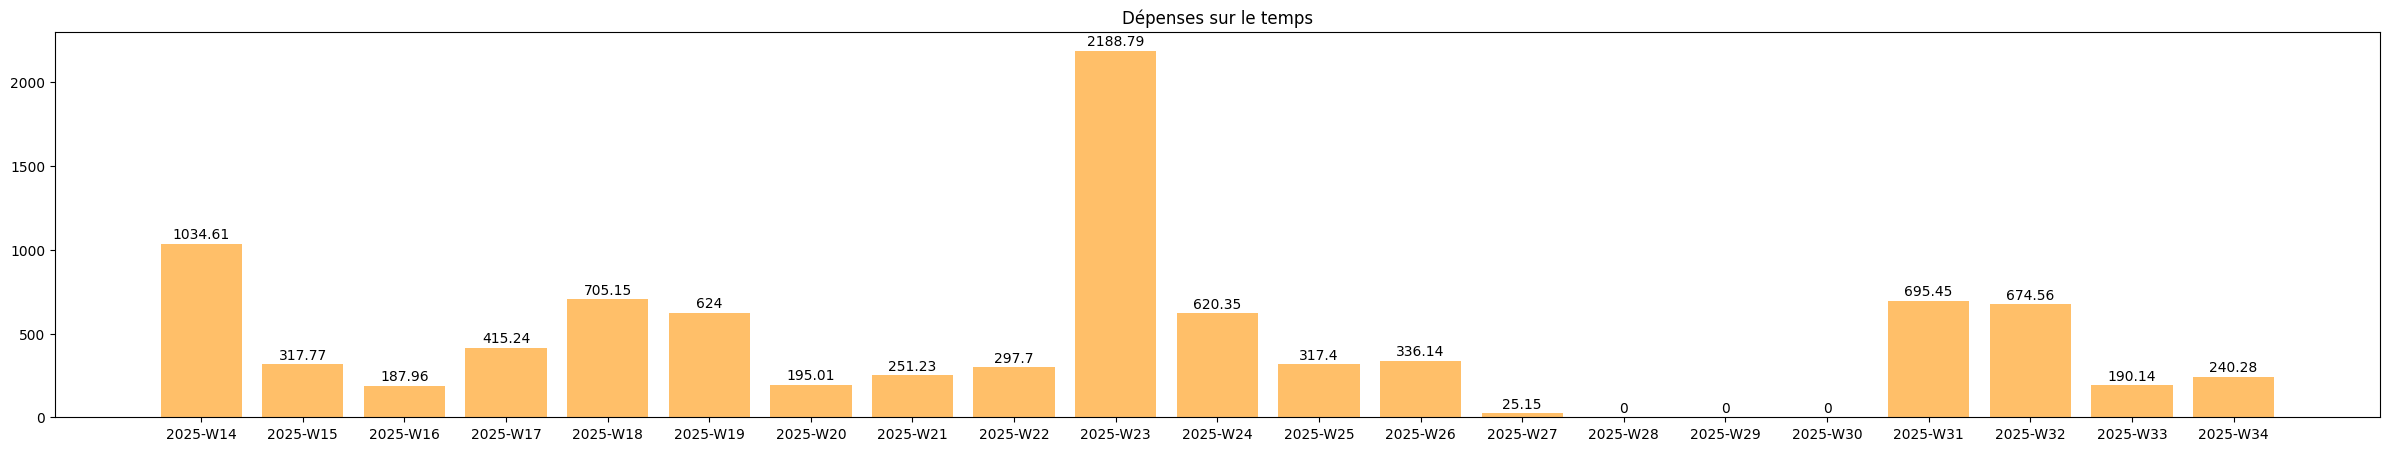

In [468]:
plot_entree_sur_temps(page_3_data, 'week')
plot_depenses_sur_temps(page_3_data, 'week')

## 📜 Page N°4

# 🔮 Experiments